### CNN without Autoencoders

Autoencoders reproduce the input but our objective is to predict C Peptide AUC Levels

This is a notebook showing just that

In [1]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
# === Feature Data Paths (raw tidy files) ===
feature_paths = {
    "SDY569": "data/SDY569_tidy.csv",
    "SDY797": "data/SDY797_tidy.csv",
    "SDY1737": "data/SDY1737_tidy.csv"
}

# === Ground Truth C-Peptide Labels ===
cpeptide_paths = {
    "SDY569": "data/SDY569_cpeptide_auc_tidy.csv",
    "SDY797": "data/SDY797_cpeptide_auc_tidy.csv",
    "SDY1737": "data/SDY1737_cpeptide_auc_tidy.csv"
}

# === CNN Output Features (Used for Ridge Regression) ===
# These were saved from the trained CNNs, so they include "Accession" for alignment
cnn_test_feature_paths = {
    "SDY569": "test_data/SDY569_3x3_test.csv",
    "SDY797": "test_data/SDY797_3x3_test.csv",
    "SDY1737": "test_data/SDY1737_3x3_test.csv"
}

## note about SDY797 - results on Autoantibodies were positive or negative -- not a continuous value

In [3]:
import pandas as pd
import numpy as np

# These are already defined:
# feature_paths, cpeptide_paths

standard_features = [
    "MIAA", "GAD65", "IA2IC", "ICA", "ZNT8",  # autoantibodies
    "8-12", "13-17", ">18", "Sex"            # age + sex indicators
]

cleaned_data = {}

for study in feature_paths:
    print(f"\n=== Preprocessing {study} ===")

    # Load
    df_feat = pd.read_csv(feature_paths[study])
    df_cpep = pd.read_csv(cpeptide_paths[study])

    if "Accession" in df_feat.columns:
        df_feat = df_feat.rename(columns={"Accession": "Subject_ID"})

    # One-hot encode Age_Group
    df_feat = pd.get_dummies(df_feat, columns=["Age_Group"])

    # Pivot
    df_wide = df_feat.pivot_table(
        index=["Subject_ID", "Sex"],
        columns="Property",
        values="Value"
    ).reset_index()

    # Map sex to binary
    df_wide["Sex"] = df_wide["Sex"].map({"Male": 0, "Female": 1})

    # One-hot columns might be missing — manually add expected age group indicators
    for col in ["Age_Group_8-12", "Age_Group_13-17", "Age_Group_>18"]:
        if col not in df_feat.columns:
            df_feat[col] = 0

    # Add age group columns to wide format
    df_age = df_feat.groupby("Subject_ID")[["Age_Group_8-12", "Age_Group_13-17", "Age_Group_>18"]].max().reset_index()
    df_wide = pd.merge(df_wide, df_age, on="Subject_ID", how="left")

    # Rename age group columns to match standard features
    df_wide = df_wide.rename(columns={
        "Age_Group_8-12": "8-12",
        "Age_Group_13-17": "13-17",
        "Age_Group_>18": ">18"
    })

    # Merge with labels
    df = pd.merge(df_wide, df_cpep, on="Subject_ID", how="inner")

    # Fill missing features with 0 (not NaN)
    for feat in standard_features:
        if feat not in df.columns:
            df[feat] = 0.0

    # Final order
    df = df[["Subject_ID"] + standard_features + ["C_Peptide_AUC_4Hrs"]]

    # Display for inspection
    print(df.head(3))
    cleaned_data[study] = df



=== Preprocessing SDY569 ===
  Subject_ID  MIAA  GAD65  IA2IC  ICA  ZNT8   8-12  13-17  >18  Sex  \
0  SUB151307  2.08  0.040   0.71  0.0   0.0   True  False    0    1   
1  SUB151308  0.01  0.430   0.00  0.0   0.0  False  False    0    0   
2  SUB151309  0.05  0.343   0.26  0.0   0.0   True  False    0    0   

   C_Peptide_AUC_4Hrs  
0              0.5625  
1              0.7156  
2              0.2875  

=== Preprocessing SDY797 ===
  Subject_ID  MIAA  GAD65  IA2IC  ICA  ZNT8  8-12  13-17  >18  Sex  \
0  SUB168890   1.0    1.0    0.0  1.0   1.0  True      0    0    0   
1  SUB168891   1.0    1.0    0.0  1.0   0.0  True      0    0    1   
2  SUB168892   1.0    1.0    1.0  1.0   1.0  True      0    0    0   

   C_Peptide_AUC_4Hrs  
0            0.860031  
1            0.771851  
2            0.523187  

=== Preprocessing SDY1737 ===
  Subject_ID   MIAA  GAD65  IA2IC  ICA   ZNT8   8-12  13-17  >18  Sex  \
0  SUB228868  0.013  396.0    0.0  0.0  0.058  False   True    0    1   
1  SU


=== Training Local CNN for SDY569 ===


array([[2.08, 0.04, 0.71, 0.0, 0.0, True, False, 0, 1],
       [0.01, 0.43, 0.0, 0.0, 0.0, False, False, 0, 0],
       [0.05, 0.343, 0.26, 0.0, 0.0, True, False, 0, 0],
       [0.02, 0.109, -0.01, 0.0, 0.0, True, False, 0, 0],
       [-0.01, 1.09, 0.0, 0.0, 0.0, False, True, 0, 0],
       [0.21, 0.33, 0.54, 0.0, 0.0, False, False, 0, 0],
       [0.04, 0.03, 1.13, 0.0, 0.0, True, False, 0, 0],
       [0.01, 0.81, 0.0, 0.0, 0.0, False, False, 0, 1],
       [0.2, 0.94, 0.02, 0.0, 0.0, True, False, 0, 1],
       [0.7, 0.39, 1.06, 0.0, 0.0, True, False, 0, 0]], dtype=object)

array([-0.57536414, -0.33463393, -1.24653242, -0.90337451,  0.44231121,
       -0.30870144, -0.35967945,  0.25192535, -1.88321708, -0.72278199])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  Avg MSE:    0.3178
  Median MSE: 0.1330
  IQR:        0.1585


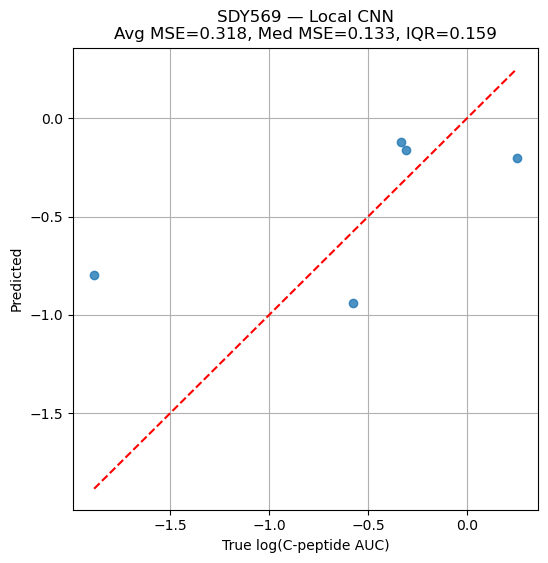


=== Training Local CNN for SDY797 ===


array([[1.0, 1.0, 0.0, 1.0, 1.0, True, 0, 0, 0],
       [1.0, 1.0, 0.0, 1.0, 0.0, True, 0, 0, 1],
       [1.0, 1.0, 1.0, 1.0, 1.0, True, 0, 0, 0],
       [0.0, 1.0, 1.0, 0.0, 1.0, True, 0, 0, 1],
       [0.0, 1.0, 1.0, 1.0, 1.0, True, 0, 0, 0],
       [0.0, 1.0, 1.0, 0.0, 0.0, True, 0, 0, 0],
       [0.0, 1.0, 1.0, 1.0, 1.0, True, 0, 0, 0],
       [0.0, 1.0, 1.0, 1.0, 1.0, True, 0, 0, 0],
       [1.0, 1.0, 1.0, 0.0, 1.0, True, 0, 0, 1],
       [1.0, 1.0, 1.0, 0.0, 0.0, True, 0, 0, 0],
       [0.0, 1.0, 0.0, 0.0, 0.0, True, 0, 0, 1],
       [0.0, 1.0, 1.0, 0.0, 1.0, True, 0, 0, 1],
       [1.0, 1.0, 0.0, 0.0, 1.0, True, 0, 0, 1],
       [1.0, 0.0, 1.0, 0.0, 1.0, True, 0, 0, 0],
       [1.0, 1.0, 1.0, 1.0, 1.0, True, 0, 0, 0],
       [1.0, 1.0, 0.0, 0.0, 1.0, True, 0, 0, 0],
       [0.0, 0.0, 1.0, 0.0, 1.0, True, 0, 0, 0],
       [0.0, 1.0, 0.0, 1.0, 1.0, True, 0, 0, 0],
       [0.0, 1.0, 0.0, 1.0, 0.0, True, 0, 0, 1],
       [1.0, 1.0, 1.0, 1.0, 0.0, True, 0, 0, 0],
       [1.0, 1.0, 1.

array([-0.15078673, -0.25896424, -0.64781657, -0.3379912 , -1.19037813,
        0.22561537, -0.34271591,  0.00359587,  0.47867549, -0.60193031,
       -0.87291438, -0.07490204,  0.13178579, -0.709935  , -0.75194131,
       -0.18404773,  0.36043571, -0.71888751, -0.68630998, -0.54584256,
       -0.27233966, -0.34863503,  0.33427227,  0.11103616, -0.16039435,
       -0.43524671, -0.31760577, -0.38293092, -0.15645555, -0.14694542,
        0.50853976, -0.53686672,  0.16289395, -0.29359619, -1.13895283,
       -0.45331172,  0.35805243, -0.5924391 , -0.52219996, -0.22354949,
       -0.603652  , -1.5019255 , -0.08442325, -0.31427184, -0.54933016,
       -1.32917116, -0.73439668, -0.31952604, -0.09511612])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Avg MSE:    0.4235
  Median MSE: 0.3035
  IQR:        0.5793


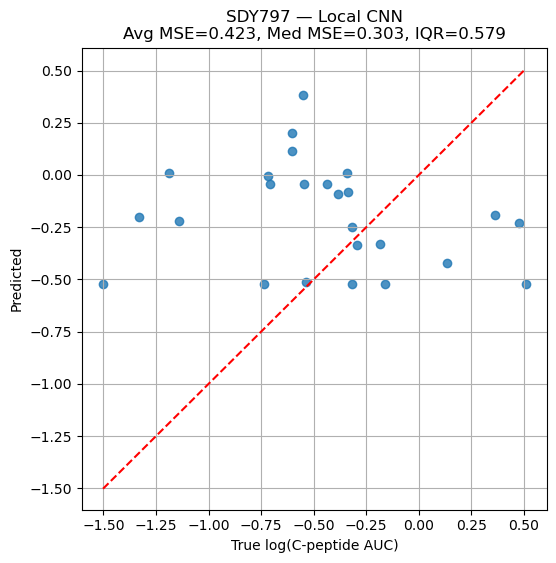


=== Training Local CNN for SDY1737 ===


array([[0.013, 396.0, 0.0, 0.0, 0.058, False, True, 0, 1],
       [0.761, 3.0, 1.0, 0.0, 0.003, True, False, 0, 1],
       [0.07, 10.0, 0.0, 0.0, 0.165, True, False, 0, 0],
       [0.299, 202.0, 295.0, 0.0, 0.039, False, True, 0, 0],
       [0.033, 520.0, 0.0, 0.0, 0.009, True, False, 0, 1],
       [0.008, 190.0, 0.0, 0.0, 0.001, False, True, 0, 0],
       [0.059, 401.0, 94.0, 0.0, 0.227, False, True, 0, 0],
       [1.437, 11.0, 0.0, 0.0, -0.005, False, False, 0, 0],
       [0.0, 551.0, 2.0, 0.0, 0.015, False, False, 0, 0],
       [0.001, 16.0, 363.0, 0.0, 0.529, True, False, 0, 0],
       [0.049, 0.0, 350.0, 0.0, 0.15, False, True, 0, 0],
       [0.21, 83.0, 2.0, 0.0, 0.001, False, True, 0, 1],
       [0.003, 570.0, 301.0, 0.0, 1.142, False, False, 0, 0],
       [0.012, 57.0, 281.0, 0.0, 0.083, False, False, 0, 0],
       [0.017, 74.0, 283.0, 0.0, -0.01, True, False, 0, 1],
       [0.007, 661.0, 3.0, 0.0, 0.173, False, False, 0, 1]], dtype=object)

array([-0.0593615 , -0.30846902, -1.45896923, -0.7800904 ,  0.19272025,
       -0.43242108, -0.10047036, -0.16485034, -0.16758468, -0.06784429,
       -0.47146044, -0.57620422,  0.41919468, -2.12989571, -0.01971286,
       -0.49381257])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  Avg MSE:    0.6336
  Median MSE: 0.0939
  IQR:        0.5143


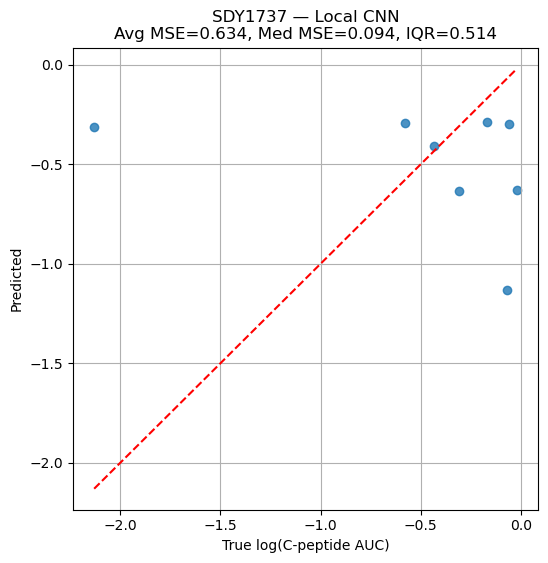

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error

# Ensure output directories exist
os.makedirs("figures/pdf", exist_ok=True)
os.makedirs("figures/html", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/cleaned", exist_ok=True)

standard_features = [
    "MIAA", "GAD65", "IA2IC", "ICA", "ZNT8",  # autoantibodies
    "8-12", "13-17", ">18", "Sex"            # age + sex indicators
]

# === Local Training Loop ===
for study, df in cleaned_data.items():
    print(f"\n=== Training Local CNN for {study} ===")

    # Fill any remaining NaNs (shouldn't be many if cleaned correctly)
    df = df.fillna(0.0)

    # Log-transform AUC
    df["log_auc"] = np.log(df["C_Peptide_AUC_4Hrs"])

    # Extract features and target
    X = df[standard_features].values
    y = df["log_auc"].values

    display(X)
    display(y)

    # Split 50/50
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # Save cleaned full dataset
    df.to_csv(f"data/cleaned/{study}_cleaned.csv", index=False)

    # Save train/test splits using Subject_IDs
    subject_ids = df["Subject_ID"].values
    train_ids = subject_ids[:len(X_train)]
    test_ids = subject_ids[len(X_train):]

    df_train = df[df["Subject_ID"].isin(train_ids)]
    df_test = df[df["Subject_ID"].isin(test_ids)]

    df_train.to_csv(f"data/cleaned/{study}_train.csv", index=False)
    df_test.to_csv(f"data/cleaned/{study}_test.csv", index=False)


    # Normalize
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Reshape for CNN
    X_train_cnn = X_train_scaled.reshape(-1, 3, 3, 1)
    X_test_cnn  = X_test_scaled.reshape(-1, 3, 3, 1)

    # --- Define CNN ---
    model = models.Sequential([
        layers.Input(shape=(3, 3, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Predict log(AUC)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train_cnn, y_train, epochs=100, batch_size=8, verbose=0)

    # Predict
    y_pred = model.predict(X_test_cnn).flatten()

    # Save model weights
    model.save(f"models/{study}_local_cnn.keras")

    # --- Metrics ---
    squared_errors = (y_test - y_pred) ** 2
    avg_mse = np.mean(squared_errors)
    median_mse = np.median(squared_errors)
    iqr = np.percentile(squared_errors, 75) - np.percentile(squared_errors, 25)

    print(f"  Avg MSE:    {avg_mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    # --- Matplotlib Plot ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True log(C-peptide AUC)")
    plt.ylabel("Predicted")
    plt.title(f"{study} — Local CNN\nAvg MSE={avg_mse:.3f}, Med MSE={median_mse:.3f}, IQR={iqr:.3f}")
    plt.grid(True)

    # Save plot
    plt.savefig(f"figures/pdf/{study}_local_cnn.pdf")
    plt.show()

    # --- Plotly Interactive Plot ---
    df_plot = pd.DataFrame({
        "True log(AUC)": y_test,
        "Predicted": y_pred
    })

    fig = px.scatter(
        df_plot, x="True log(AUC)", y="Predicted",
        title=f"{study} — Local CNN (Interactive)",
        labels={"x": "True log(C‑peptide AUC)", "y": "Predicted"},
        width=600, height=600
    )
    fig.add_shape(
        type="line",
        x0=y_test.min(), y0=y_test.min(),
        x1=y_test.max(), y1=y_test.max(),
        line=dict(color="red", dash="dash")
    )
    fig.write_html(f"figures/html/{study}_local_cnn.html")
